In [1]:
import fastai
from fastai.vision import *
from fastai.callbacks import *
from fastai.torch_core import *
from fastai.callback import *
from fastai.basic_train import *
import torchvision.models as tmodels

In [2]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import accuracy_score
from scipy.misc import imsave

In [3]:
trainPath = '/home/santhosr/Documents/Birad/ProcessedData/FullRes_Sampled/'

In [9]:
data = (ImageItemList.from_folder(trainPath).random_split_by_pct(seed=40).label_from_folder().transform(get_transforms(),size=512).databunch(bs=5))

In [10]:
learn = create_cnn(data, tmodels.densenet121, metrics=accuracy,pretrained=False)

/home/santhosr/.conda/envs/fastai/lib/python3.6/site-packages/torchvision/models/densenet.py:212: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  nn.init.kaiming_normal(m.weight.data)


In [6]:
class ModelTrackerCallback(TrackerCallback):
    "A `TrackerCallback` that saves the model when monitored quantity is best."
    def __init__(self, learn:Learner, monitor:str='val_loss', mode:str='auto', prefix:str='resnet50'):
        super().__init__(learn, monitor=monitor, mode=mode)
        
        self.bestAcc = 0.0001
        super().__post_init__()

    def on_epoch_end(self, epoch, **kwargs:Any)->None:
        "Compare the value monitored to its best score and maybe save the model."

        acc = float(self.learn.recorder.metrics[epoch-1][0])
        val_loss = self.learn.recorder.val_losses[epoch-1]

        if acc>self.bestAcc:
            self.bestAcc = acc
            self.learn.save(f'model_acc{int(acc*1000)}_loss{int(val_loss*1000)}')



### Training

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


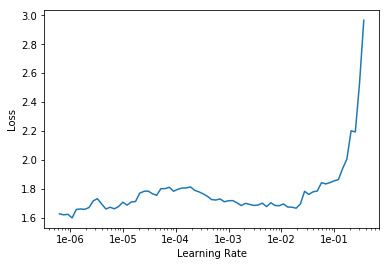

In [11]:
learn.lr_find()
learn.recorder.plot()

In [24]:
best_model_cb = partial(ModelTrackerCallback)
learn.callback_fns.append(best_model_cb)

In [16]:
learn.model[0]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1

In [7]:
learn.fit_one_cycle(10,0.000001)

epoch,train_loss,valid_loss,accuracy
1,1.245817,1.070036,0.554167
2,1.194054,0.995442,0.580556
3,1.108025,0.915941,0.581944
4,1.052848,0.840256,0.623611
5,1.014347,0.810737,0.645833
6,0.925363,0.814010,0.637500
7,0.923887,0.804744,0.636111
8,0.913687,0.796922,0.645833
9,0.925815,0.790815,0.651389
10,0.967387,0.795558,0.640278


In [24]:
learn.fit(1, slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy
1,1.496402,2.482855,0.309722


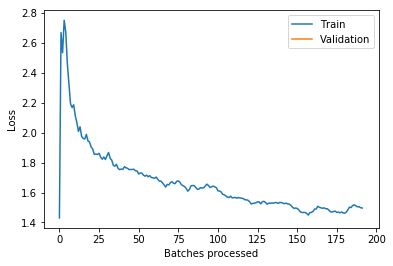

In [31]:

learn.recorder.plot_losses()
plt.savefig('dot.png')

In [30]:
import matplotlib.pyplot as plt


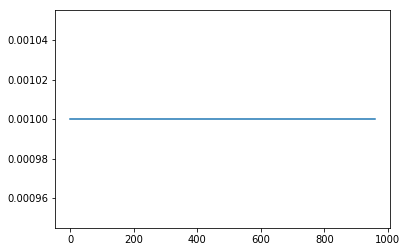

In [12]:
learn.recorder.plot_lr()

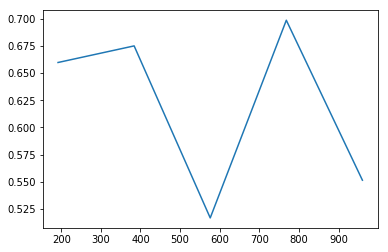

In [14]:
learn.recorder.plot_metrics()

### Results

In [13]:
interp = ClassificationInterpretation.from_learner(learn)

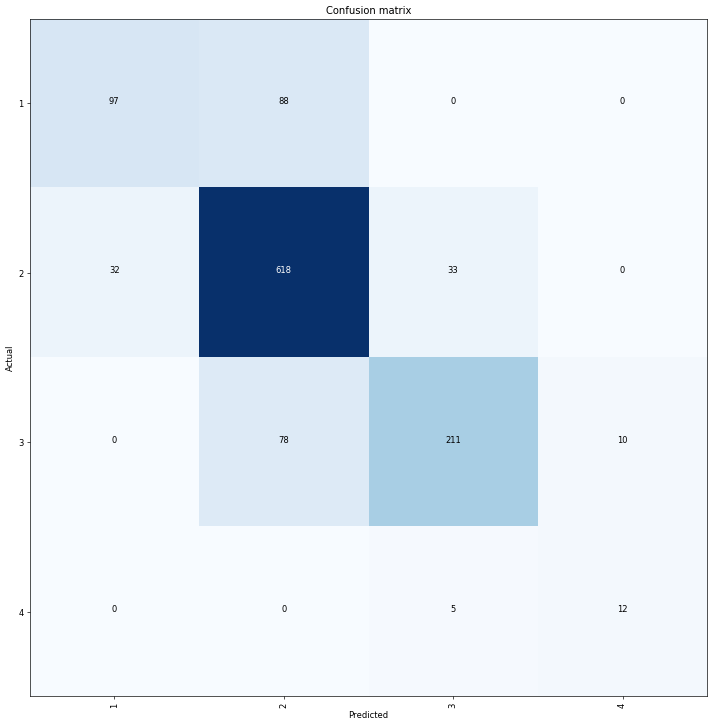

In [14]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)